# A Rubric for Data Wrangling and Exploration

Companion to Lecture 4 of [Harvard CS109: Data Science](http://cs109.org) | Prepared by [Chris Beaumont](http://chrisbeaumont.org)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

I'd like to suggest a basic rubric for the early stages of exploratory data analysis in Python. This isn't universally applicable, but it does cover many patterns which recur in several data analysis contexts. It's useful to keep this rubric in mind when encountering a new  dataset.

The basic workflow is as follows:

1. **Build** a DataFrame from the data (ideally, put *all* data in this object)
2. **Clean** the DataFrame. It should have the following properties:
   * Each row describes a single object
   * Each column describes a property of that object
   * Columns are numeric whenever appropriate
   * Columns contain atomic properties that cannot be further decomposed
3. Explore **global properties**. Use histograms, scatter plots, and aggregation functions to summarize the data.
4. Explore **group properties**. Use groupby and small multiples to compare subsets of the data.

This process transforms your data into a format which is easier to work with, gives you a basic overview of 
the data's properties, and likely generates several questions for you to followup in subsequent analysis.

Here's a preview of the raw data we'll use -- it's a list of the 10,000 movies made since 1950 with the most IMDB user ratings. It was scraped about a year ago from [pages like this](http://www.imdb.com/search/title?sort=num_votes,desc&title_type=feature&year=1950,2012). Download the data at [http://bit.ly/cs109_imdb](http://bit.ly/cs109_imdb).

In [2]:
!head imdb_top_10000.txt

tt0111161	The Shawshank Redemption (1994)	1994	 9.2	619479	142 mins.	Crime|Drama
tt0110912	Pulp Fiction (1994)	1994	 9.0	490065	154 mins.	Crime|Thriller
tt0137523	Fight Club (1999)	1999	 8.8	458173	139 mins.	Drama|Mystery|Thriller
tt0133093	The Matrix (1999)	1999	 8.7	448114	136 mins.	Action|Adventure|Sci-Fi
tt1375666	Inception (2010)	2010	 8.9	385149	148 mins.	Action|Adventure|Sci-Fi|Thriller
tt0109830	Forrest Gump (1994)	1994	 8.7	368994	142 mins.	Comedy|Drama|Romance
tt0169547	American Beauty (1999)	1999	 8.6	338332	122 mins.	Drama
tt0499549	Avatar (2009)	2009	 8.1	336855	162 mins.	Action|Adventure|Fantasy|Sci-Fi
tt0108052	Schindler's List (1993)	1993	 8.9	325888	195 mins.	Biography|Drama|History|War
tt0080684	Star Wars: Episode V - The Empire Strikes Back (1980)	1980	 8.8	320105	124 mins.	Action|Adventure|Family|Sci-Fi


## 1. Build a DataFrame

The textfile is tab-separated, and doesn't have any column headers. We
set the appropriate keywords in `pd.read_csv` to handle this

In [3]:
data = pd.read_csv('imdb_top_10000.txt', sep='\t', header=None) # names=names
data.columns = ['imdbID', 'title', 'year', 'score', 'votes', 'runtime', 'genres']
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142 mins.,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154 mins.,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139 mins.,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136 mins.,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148 mins.,Action|Adventure|Sci-Fi|Thriller


In [4]:
data[data.isnull().any(axis=1)]
data = data.dropna()

## 2. Clean the DataFrame

There are several problems with the DataFrame at this point:

1. The runtime column describes a number, but is stored as a string
2. The genres column is not atomic -- it aggregates several genres together. This makes it hard, for example, to extract which movies are Comedies.
3. The movie year is repeated in the title and year column

### Fixing the runtime column

The following snipptet converts a string like '142 mins.' to the number 142:

In [5]:
data['runtime'] = data['runtime'].apply(lambda x: float(x.split()[0]))
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148,Action|Adventure|Sci-Fi|Thriller


## Create columns from column - Splitting up the genres

We can use the concept of *indicator variables* to split the genres column into many columns. Each new column will correspond to a single genre, and each cell will be True or False.

In [6]:
genres = list(set(c for b in data.genres.apply(lambda x: x.split('|')).values for c in b))
for genre in genres:
    data[genre] = data.genres.apply(lambda x: 1 if genre in x else 0)

data.head()

,imdbID,title,year,score,votes,runtime,genres,Sci-Fi,Crime,Romance,Animation,Music,Comedy,War,Horror,Film-Noir,Adult,News,Reality-TV,Thriller,Western,Mystery,Drama,Action,Musical,History,Family,Adventure,Fantasy,Sport,Biography
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142,Crime|Drama,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154,Crime|Thriller,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,tt0137523,Fight Club (1999),1999,8.8,458173,139,Drama|Mystery|Thriller,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0
3,tt0133093,The Matrix (1999),1999,8.7,448114,136,Action|Adventure|Sci-Fi,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,tt1375666,Inception (2010),2010,8.9,385149,148,Action|Adventure|Sci-Fi|Thriller,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


### Removing year from the title
We can fix each element by stripping off the last 7 characters

In [7]:
data['title'] = data['title'].apply(lambda x: x[:-7])
data.head()

,imdbID,title,year,score,votes,runtime,genres,Sci-Fi,Crime,Romance,Animation,Music,Comedy,War,Horror,Film-Noir,Adult,News,Reality-TV,Thriller,Western,Mystery,Drama,Action,Musical,History,Family,Adventure,Fantasy,Sport,Biography
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142,Crime|Drama,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,tt0110912,Pulp Fiction,1994,9.0,490065,154,Crime|Thriller,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,tt0137523,Fight Club,1999,8.8,458173,139,Drama|Mystery|Thriller,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0
3,tt0133093,The Matrix,1999,8.7,448114,136,Action|Adventure|Sci-Fi,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,tt1375666,Inception,2010,8.9,385149,148,Action|Adventure|Sci-Fi|Thriller,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


## 3. Explore global properties

Next, we get a handle on some basic, global summaries of the DataFrame.

### Call `describe` on relevant columns

In [8]:
data[['score', 'runtime', 'year', 'votes']].describe()

,score,runtime,year,votes
count,9999.000000,9999.000000,9999.000000,9999.000000
mean,6.385989,103.580358,1993.471447,16605.462946
std,1.189965,26.629310,14.830049,34564.883945
min,1.500000,0.000000,1950.000000,1356.000000
25%,5.700000,93.000000,1986.000000,2334.500000
50%,6.600000,102.000000,1998.000000,4981.000000
75%,7.200000,115.000000,2005.000000,15278.500000
max,9.200000,450.000000,2011.000000,619479.000000


In [9]:
#hmmm, a runtime of 0 looks suspicious. How many movies have that?
print len(data[data.runtime == 0])

#probably best to flag those bad data as NAN
data.loc[data.runtime==0, 'runtime'] = np.nan

282


After flagging bad runtimes, we repeat

In [10]:
data.runtime.describe()

count    9717.000000
mean      106.586395
std        20.230330
min        45.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       450.000000
Name: runtime, dtype: float64

### Make some basic plots

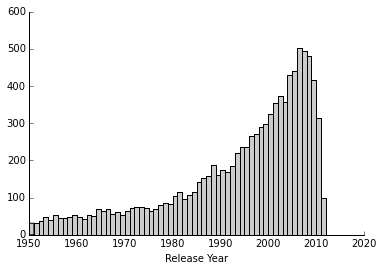

In [11]:
# more movies in recent years, but not *very* recent movies (they haven't had time to receive lots of votes yet?)
plt.hist(data.year, bins=np.arange(1950, 2013), color='#cccccc')
plt.xlabel("Release Year")
remove_border()

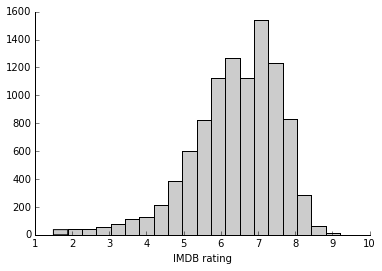

In [12]:
plt.hist(data.score, bins=20, color='#cccccc')
plt.xlabel("IMDB rating")
remove_border()

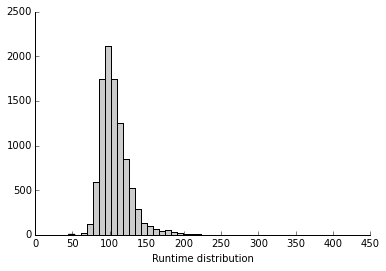

In [13]:
plt.hist(data.runtime.dropna(), bins=50, color='#cccccc')
plt.xlabel("Runtime distribution")
remove_border()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


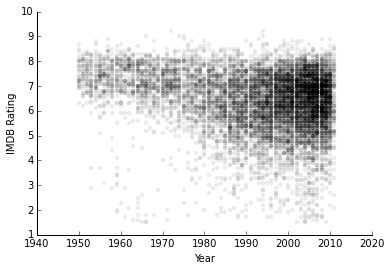

In [14]:
#hmm, more bad, recent movies. Real, or a selection bias?

plt.scatter(data.year, data.score, lw=0, alpha=.08, color='k')
plt.xlabel("Year")
plt.ylabel("IMDB Rating")
remove_border()

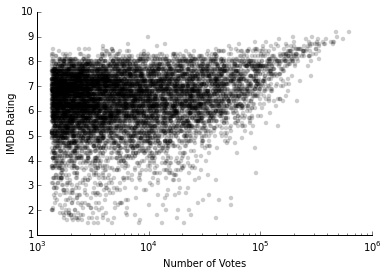

In [15]:
plt.scatter(data.votes, data.score, lw=0, alpha=.2, color='k')
plt.xlabel("Number of Votes")
plt.ylabel("IMDB Rating")
plt.xscale('log')
remove_border()

### Identify some outliers

In [16]:
# low-score movies with lots of votes
data[(data.votes > 9e4) & (data.score < 5)][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
317,New Moon,2009,4.5,90457,Adventure|Drama|Fantasy|Romance
334,Batman & Robin,1997,3.5,91875,Action|Crime|Fantasy|Sci-Fi


In [17]:
# The lowest rated movies
data[data.score == data.score.min()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
1982,Manos: The Hands of Fate,1966,1.5,20927,Horror
2793,Superbabies: Baby Geniuses 2,2004,1.5,13196,Comedy|Family
3746,Daniel the Wizard,2004,1.5,8271,Comedy|Crime|Family|Fantasy|Horror
5158,Ben & Arthur,2002,1.5,4675,Drama|Romance
5993,Night Train to Mundo Fine,1966,1.5,3542,Action|Adventure|Crime|War
6257,Monster a-Go Go,1965,1.5,3255,Sci-Fi|Horror
6726,Dream Well,2009,1.5,2848,Comedy|Romance|Sport


In [18]:
# The highest rated movies
data[data.score == data.score.max()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
0,The Shawshank Redemption,1994,9.2,619479,Crime|Drama
26,The Godfather,1972,9.2,474189,Crime|Drama


### Run aggregation functions like `sum` over several rows or columns

*What genres are the most frequent?*

In [19]:
data[list(genres)].sum(axis=0).sort_values(ascending=False)

Drama         5697
Comedy        3922
Thriller      2832
Romance       2441
Action        1891
Crime         1867
Adventure     1313
Horror        1215
Mystery       1009
Fantasy        916
Sci-Fi         897
Family         754
Music          619
War            512
Biography      394
History        358
Animation      314
Sport          288
Musical        260
Western        235
Film-Noir       40
Adult            9
News             1
Reality-TV       1
dtype: int64

*How many genres does a movie have, on average?*

In [20]:
data[list(genres)].sum(axis=1).describe()

count    9999.000000
mean        2.778778
std         1.201064
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
dtype: float64

## Explore Group Properties

Let's split up movies by decade

In [21]:
decade =  (data.year // 10) * 10

tyd = data[['title', 'year']]
tyd['decade'] = decade

tyd.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,title,year,decade
0,The Shawshank Redemption,1994,1990
1,Pulp Fiction,1994,1990
2,Fight Club,1999,1990
3,The Matrix,1999,1990
4,Inception,2010,2010


[GroupBy](http://pandas.pydata.org/pandas-docs/dev/groupby.html) will gather movies into groups with equal decade values

year
1950    7.244522
1960    7.062367
1970    6.842297
1980    6.248693
1990    6.199316
2000    6.277858
2010    6.344552
Name: Decade Mean, dtype: float64


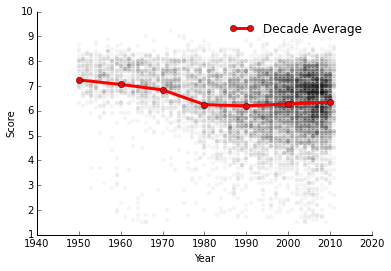

In [22]:
#mean score for all movies in each decade
decade_mean = data.groupby(decade).score.mean()
decade_mean.name = 'Decade Mean'
print decade_mean

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)
remove_border()

We can go one further, and compute the scatter in each year as well

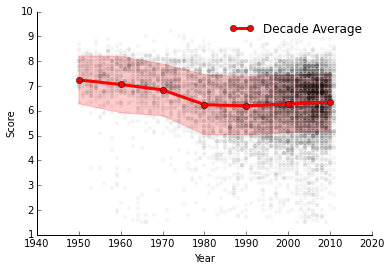

In [23]:
grouped_scores = data.groupby(decade).score

mean = grouped_scores.mean()
std = grouped_scores.std()

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.fill_between(decade_mean.index, (decade_mean + std).values,
                 (decade_mean - std).values, color='r', alpha=.2)
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)
remove_border()

You can also iterate over a GroupBy object. Each iteration yields two variables: one of the distinct values of the group key, and the subset of the dataframe where the key equals that value. To find the most popular movie each year:


In [24]:
for year, subset in data.groupby('year'):
    print year, subset[subset.score == subset.score.max()].title.values[0]

1950 Sunset Blvd.
1951 Strangers on a Train
1952 Singin' in the Rain
1953 The Wages of Fear
1954 Seven Samurai
1955 Diabolique
1956 The Killing
1957 12 Angry Men
1958 Vertigo
1959 North by Northwest
1960 Psycho
1961 Yojimbo
1962 To Kill a Mockingbird
1963 The Great Escape
1964 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
1965 For a Few Dollars More
1966 The Good, the Bad and the Ugly
1967 Cool Hand Luke
1968 Once Upon a Time in the West
1969 Butch Cassidy and the Sundance Kid
1970 Patton
1971 A Clockwork Orange
1972 The Godfather
1973 The Sting
1974 The Godfather: Part II
1975 Outrageous Class
1976 Tosun Pasa
1977 Star Wars: Episode IV - A New Hope
1978 The Girl with the Red Scarf
1979 Apocalypse Now
1980 Star Wars: Episode V - The Empire Strikes Back
1981 Raiders of the Lost Ark
1982 The Marathon Family
1983 Star Wars: Episode VI - Return of the Jedi
1984 Balkan Spy
1985 The Broken Landlord
1986 Aliens
1987 Mr. Muhsin
1988 Cinema Paradiso
1989 Indiana Jones and

### Small multiples

Let's split up the movies by genre, and look at how their release year/runtime/IMDB score vary.
The distribution for all movies is shown as a grey background.

This isn't a standard groupby, so we can't use the `groupby` method here. A manual loop is needed

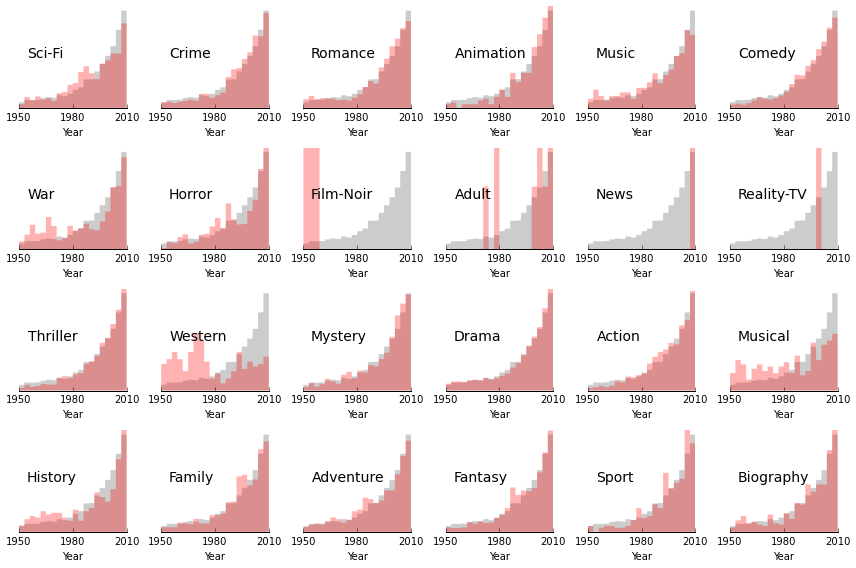

In [41]:
#create a 4x6 grid of plots.
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), 
                         tight_layout=True)

bins = np.arange(1950, 2013, 3)
for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].year.values, 
            bins=bins, histtype='stepfilled', normed=True, color='r', alpha=.3, ec='none')
    ax.hist(data.year, bins=bins, histtype='stepfilled', ec='None', normed=True, zorder=0, color='#cccccc')
    
    ax.annotate(genre, xy=(1955, 3e-2), fontsize=14)
    ax.xaxis.set_ticks(np.arange(1950, 2013, 30))
    ax.set_yticks([])
    remove_border(ax, left=False)
    ax.set_xlabel('Year')

Some subtler patterns here:

1. Westerns and Musicals have a more level distribution
2. Film Noir movies were much more popular in the 50s and 60s

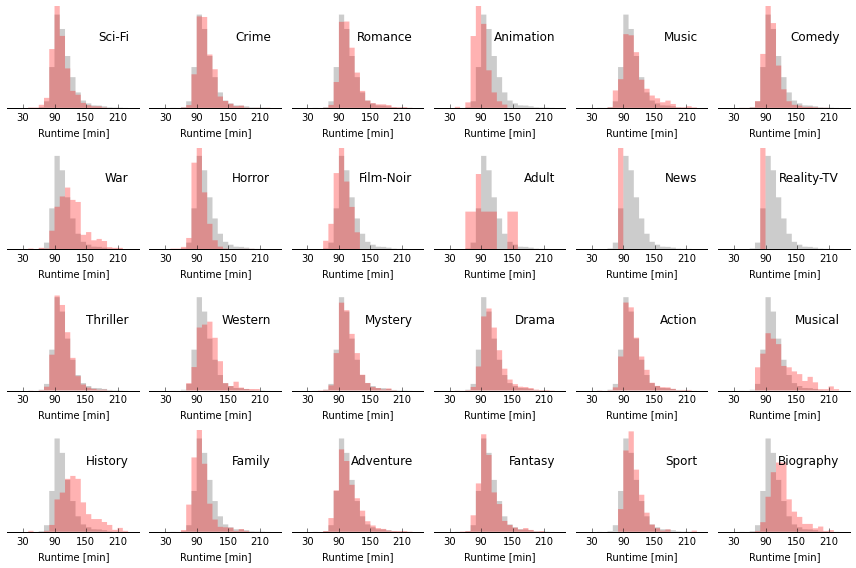

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(30, 240, 10)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].runtime.values, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, normed=True)
               
    ax.hist(data.runtime, bins=bins, normed=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_xticks(np.arange(30, 240, 60))
    ax.set_yticks([])
    ax.set_xlabel("Runtime [min]")
    remove_border(ax, left=False)
    ax.annotate(genre, xy=(230, .02), ha='right', fontsize=12)

1. Biographies and history movies are longer
1. Animated movies are shorter
1. Film-Noir movies have the same mean, but are more conentrated around a 100 minute runtime
1. Musicals have the same mean, but greater dispersion in runtimes

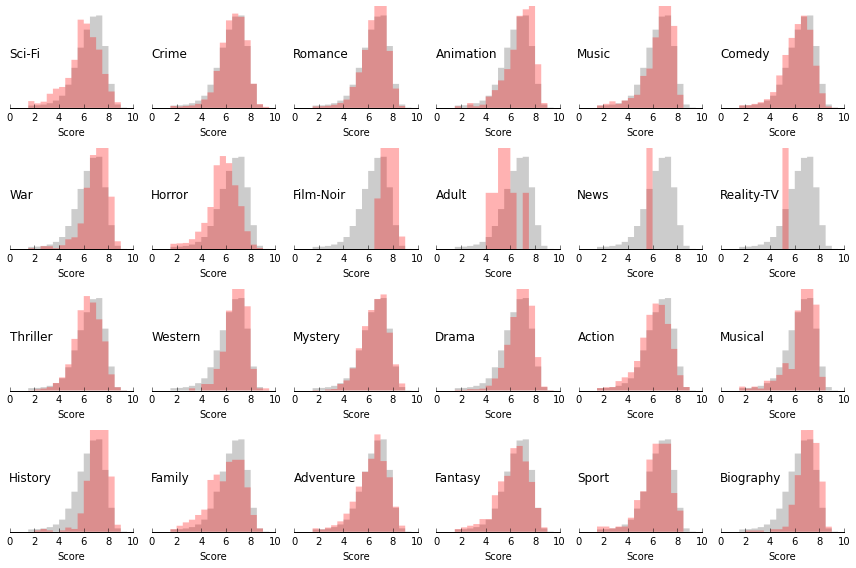

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(0, 10, .5)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].score.values, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, normed=True)
               
    ax.hist(data.score, bins=bins, normed=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_yticks([])
    ax.set_xlabel("Score")
    remove_border(ax, left=False)
    ax.set_ylim(0, .4)
    ax.annotate(genre, xy=(0, .2), ha='left', fontsize=12)

1. Film-noirs, histories, and biographies have higher ratings (a selection effect?)
1. Horror movies and adult films have lower ratings

## Other Resources

* Chapters 5 and 7 of [Python for Data Analysis](http://www.amazon.com/Python-Data-Analysis-Wes-McKinney/dp/1449319793)
* IPython notebook on [Data wrangling with Pandas](http://nbviewer.ipython.org/urls/gist.github.com/fonnesbeck/5850413/raw/3a9406c73365480bc58d5e75bc80f7962243ba17/2.+Data+Wrangling+with+Pandas.ipynb)
* [Lecture 4](https://drive.google.com/folderview?id=0BxYkKyLxfsNVd0xicUVDS1dIS0k&usp=sharing) of Harvard's CS 109: Data Science

*css tweaks in this cell*

<style> 
div.text_cell_render {
    line-height: 135%;
    font-size: 110%;
    width: 800px; 
    margin-left:50px;
    margin-right:auto;
    }
    
li {
    line-height: 135%;
}
</style>